In [ ]:
# default_exp learner

# Learner

> This contains fastai Learner extensions.

In [ ]:
#export
from fastai.learner import * 
from fastai.vision.models.all import *
from fastai.data.transforms import *
from tsai.imports import *
from tsai.data.core import *
from tsai.data.validation import *
from tsai.models.utils import *
from tsai.models.InceptionTimePlus import *

In [ ]:
#export
@patch
def show_batch(self:Learner, **kwargs):
    self.dls.show_batch(**kwargs)

In [ ]:
#export
@patch
def one_batch(self:Learner, i, b): # this fixes a bug that will be managed in the next release of fastai
    self.iter = i
#     b_on_device = tuple( e.to(device=self.dls.device) for e in b if hasattr(e, "to")) if self.dls.device is not None else b
    b_on_device = to_device(b, device=self.dls.device) if self.dls.device is not None else b
    self._split(b_on_device)
    self._with_events(self._do_one_batch, 'batch', CancelBatchException)

In [ ]:
#export
@patch
def save_all(self:Learner, path='export', dls_fname='dls', model_fname='model', learner_fname='learner', verbose=False):
    path = Path(path)
    if not os.path.exists(path): os.makedirs(path)

    self.dls_type = self.dls.__class__.__name__
    if self.dls_type == "MixedDataLoaders":
        self.n_loaders = (len(self.dls.loaders), len(self.dls.loaders[0].loaders))
        dls_fnames = []
        for i,dl in enumerate(self.dls.loaders):
            for j,l in enumerate(dl.loaders):
                l = l.new(num_workers=1)
                torch.save(l, path/f'{dls_fname}_{i}_{j}.pth')
                dls_fnames.append(f'{dls_fname}_{i}_{j}.pth')
    else:
        dls_fnames = []
        self.n_loaders = len(self.dls.loaders)
        for i,dl in enumerate(self.dls):
            dl = dl.new(num_workers=1)
            torch.save(dl, path/f'{dls_fname}_{i}.pth')
            dls_fnames.append(f'{dls_fname}_{i}.pth')

    # Saves the model along with optimizer
    self.model_dir = path
    self.save(f'{model_fname}', with_opt=True)

    # Export learn without the items and the optimizer state for inference
    self.export(path/f'{learner_fname}.pkl')
    
    pv(f'Learner saved:', verbose)
    pv(f"path          = '{path}'", verbose)
    pv(f"dls_fname     = '{dls_fnames}'", verbose)
    pv(f"model_fname   = '{model_fname}.pth'", verbose)
    pv(f"learner_fname = '{learner_fname}.pkl'", verbose)
    
    
def load_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner', device=None, pickle_module=pickle, verbose=False):

    if isinstance(device, int): device = torch.device('cuda', device)
    elif device is None: device = default_device()
    if device == 'cpu': cpu = True
    else: cpu = None

    path = Path(path)
    learn = load_learner(path/f'{learner_fname}.pkl', cpu=cpu, pickle_module=pickle_module)
    learn.load(f'{model_fname}', with_opt=True, device=device)

    
    if learn.dls_type == "MixedDataLoaders":
        dls_fnames = []
        _dls = []
        for i in range(learn.n_loaders[0]):
            _dl = []
            for j in range(learn.n_loaders[1]):
                l = torch.load(path/f'{dls_fname}_{i}_{j}.pth', map_location=device, pickle_module=pickle_module)
                l = l.new(num_workers=0)
                l.to(device)
                dls_fnames.append(f'{dls_fname}_{i}_{j}.pth')
                _dl.append(l)
            _dls.append(MixedDataLoader(*_dl, path=learn.dls.path, device=device, shuffle=l.shuffle))
        learn.dls = MixedDataLoaders(*_dls, path=learn.dls.path, device=device)

    else:
        loaders = []
        dls_fnames = []
        for i in range(learn.n_loaders):
            dl = torch.load(path/f'{dls_fname}_{i}.pth', map_location=device, pickle_module=pickle_module)
            dl = dl.new(num_workers=0)
            dl.to(device)
            first(dl)
            loaders.append(dl)
            dls_fnames.append(f'{dls_fname}_{i}.pth')
        learn.dls = type(learn.dls)(*loaders, path=learn.dls.path, device=device)


    pv(f'Learner loaded:', verbose)
    pv(f"path          = '{path}'", verbose)
    pv(f"dls_fname     = '{dls_fnames}'", verbose)
    pv(f"model_fname   = '{model_fname}.pth'", verbose)
    pv(f"learner_fname = '{learner_fname}.pkl'", verbose)
    return learn

load_learner_all = load_all

In [ ]:
#export
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, final_losses=True, perc=.5, **kwargs):
    n_values = len(self.recorder.values)
    if n_values < 2: 
        print('not enough values to plot a chart')
        return
    metrics = np.stack(self.values)
    n_metrics = metrics.shape[1]
    names = self.metric_names[1:n_metrics+1]
    if final_losses: 
        sel_idxs = int(round(n_values * perc))
        if sel_idxs >= 2:
            metrics = np.concatenate((metrics[:,:2], metrics), -1)
            names = names[:2] + names
        else: 
            final_losses = False
    n = len(names) - 1 - final_losses
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    axs = ([axs[0]]*2 + [axs[1]]*2 + axs[2:]) if final_losses else ([axs[0]]*2 + axs[1:])
    for i, (name, ax) in enumerate(zip(names, axs)):
        if i in [0, 1]:
            ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i == 1 else 'train')
            ax.set_title('losses')
            ax.set_xlim(0, len(metrics)-1)
        elif i in [2, 3] and final_losses:
            ax.plot(np.arange(len(metrics) - sel_idxs, len(metrics)), metrics[-sel_idxs:, i], 
                    color='#1f77b4' if i == 2 else '#ff7f0e', label='valid' if i == 3 else 'train')
            ax.set_title('final losses')
            ax.set_xlim(len(metrics) - sel_idxs, len(metrics)-1)
            # ax.set_xticks(np.arange(len(metrics) - sel_idxs, len(metrics)))
        else:
            ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
            ax.set_title(name if i >= 2 * (1 + final_losses) else 'losses')
            ax.set_xlim(0, len(metrics)-1)
        ax.legend(loc='best')
        ax.grid(color='gainsboro', linewidth=.5)
    plt.show()
    
    
@patch
@delegates(subplots)
def plot_metrics(self: Learner, **kwargs):
    self.recorder.plot_metrics(**kwargs)

In [ ]:
#export
@patch
@delegates(subplots)
def show_probas(self:Learner, figsize=(6,6), ds_idx=1, dl=None, one_batch=False, max_n=None, **kwargs):
    recorder = copy(self.recorder) # This is to avoid loss of recorded values while generating preds
    if one_batch: dl = self.dls.one_batch()
    probas, targets = self.get_preds(ds_idx=ds_idx, dl=[dl] if dl is not None else None)
    if probas.ndim == 2 and probas.min() < 0 or probas.max() > 1: probas = nn.Softmax(-1)(probas)
    if not isinstance(targets[0].item(), Integral): return
    targets = targets.flatten()
    if max_n is not None:
        idxs = np.random.choice(len(probas), max_n, False)
        probas, targets = probas[idxs], targets[idxs]
    fig = plt.figure(figsize=figsize, **kwargs)
    classes = np.unique(targets)
    nclasses = len(classes)
    vals = np.linspace(.5, .5 + nclasses - 1, nclasses)[::-1]
    plt.vlines(.5, min(vals) - 1, max(vals), color='black', linewidth=.5)
    cm = plt.get_cmap('gist_rainbow')
    color = [cm(1.* c/nclasses) for c in range(1, nclasses + 1)][::-1]
    class_probas = np.array([probas[i,t] for i,t in enumerate(targets)])
    for i, c in enumerate(classes):
        plt.scatter(class_probas[targets == c] if nclasses > 2 or i > 0 else 1 - class_probas[targets == c],
                    targets[targets == c] + .5 * (np.random.rand((targets == c).sum()) - .5), color=color[i], edgecolor='black', alpha=.2, s=100)
        if nclasses > 2: plt.vlines((targets == c).float().mean(), i - .5, i + .5, color='r', linewidth=.5)
    plt.hlines(vals, 0, 1)
    plt.ylim(min(vals) - 1, max(vals))
    plt.xlim(0,1)
    plt.xticks(np.linspace(0,1,11), fontsize=12)
    plt.yticks(classes, [self.dls.vocab[x] for x in classes], fontsize=12)
    plt.title('Predicted proba per true class' if nclasses > 2 else 'Predicted class 1 proba per true class', fontsize=14)
    plt.xlabel('Probability', fontsize=12)
    plt.ylabel('True class', fontsize=12)
    plt.grid(axis='x', color='gainsboro', linewidth=.2)
    plt.show()
    self.recorder = recorder

In [ ]:
#export
@delegates(build_ts_model)
def ts_learner(dls, arch=None, c_in=None, c_out=None, seq_len=None, d=None, splitter=trainable_params,
               # learner args
               loss_func=None, opt_func=Adam, lr=defaults.lr, cbs=None, metrics=None, path=None,
               model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
               # other model args
               **kwargs):

    if arch is None: arch = InceptionTimePlus
    model = build_ts_model(arch, dls=dls, c_in=c_in, c_out=c_out, seq_len=seq_len, d=d, **kwargs)
    try:
        model[0], model[1]
        subscriptable = True
    except:
        subscriptable = False
    if subscriptable: splitter = ts_splitter
    if loss_func is None:
        if hasattr(dls, 'loss_func'): loss_func = dls.loss_func
        elif hasattr(dls, 'train_ds') and hasattr(dls.train_ds, 'loss_func'): loss_func = dls.train_ds.loss_func
        elif hasattr(dls, 'cat') and not dls.cat: loss_func = MSELossFlat()
        
    learn = Learner(dls=dls, model=model,
                    loss_func=loss_func, opt_func=opt_func, lr=lr, cbs=cbs, metrics=metrics, path=path, splitter=splitter,
                    model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms, )

    # keep track of args for loggers
    store_attr('arch', self=learn)

    return learn

In [ ]:
#export
@delegates(build_tsimage_model)
def tsimage_learner(dls, arch=None, pretrained=False,
               # learner args
               loss_func=None, opt_func=Adam, lr=defaults.lr, cbs=None, metrics=None, path=None,
               model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
               # other model args
               **kwargs):

    if arch is None: arch = xresnet34
    model = build_tsimage_model(arch, dls=dls, pretrained=pretrained, **kwargs)
    learn = Learner(dls=dls, model=model,
                    loss_func=loss_func, opt_func=opt_func, lr=lr, cbs=cbs, metrics=metrics, path=path,
                    model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms)

    # keep track of args for loggers
    store_attr('arch', self=learn)

    return learn

In [ ]:
#export
@patch
def decoder(self:Learner, o): return L([self.dls.decodes(oi) for oi in o])

In [ ]:
# export

@patch
@delegates(GatherPredsCallback.__init__)
def get_X_preds(self: Learner, X, y=None, bs=64, with_input=False, with_decoded=True, with_loss=False, **kwargs):
    if with_loss and y is None:
        print('cannot find loss as y=None')
        with_loss = False
    dl = self.dls.new_dl(X, y=y)
    dl.bs = bs
    output = list(self.get_preds(dl=dl, with_input=with_input, with_decoded=with_decoded, with_loss=with_loss))
    if with_decoded:
        if hasattr(self.dls, 'vocab'):
            output[2 + with_input] = L([self.dls.vocab[p] for p in output[2 + with_input]])
        elif hasattr(self.dls, 'decode'):
            output[2 + with_input] = self.dls.decode((output[2 + with_input].to(self.dls.device), ))[0]
    return tuple(output)

In [ ]:
from tsai.data.all import *
from tsai.data.core import *
from tsai.models.FCNPlus import *
dsid = 'OliveOil'
X, y, splits = get_UCR_data(dsid, verbose=True, split_data=False)
tfms  = [None, [Categorize()]]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms)
learn = ts_learner(dls, FCNPlus)
for p in learn.model.parameters():
    p.requires_grad=False
test_eq(count_parameters(learn.model), 0)
learn.freeze()
test_eq(count_parameters(learn.model), 1540)
learn.unfreeze()
test_eq(count_parameters(learn.model), 264580)

Dataset: OliveOil
X      : (60, 1, 570)
y      : (60,)
splits : (#30) [0,1,2,3,4,5,6,7,8,9...] (#30) [30,31,32,33,34,35,36,37,38,39...] 



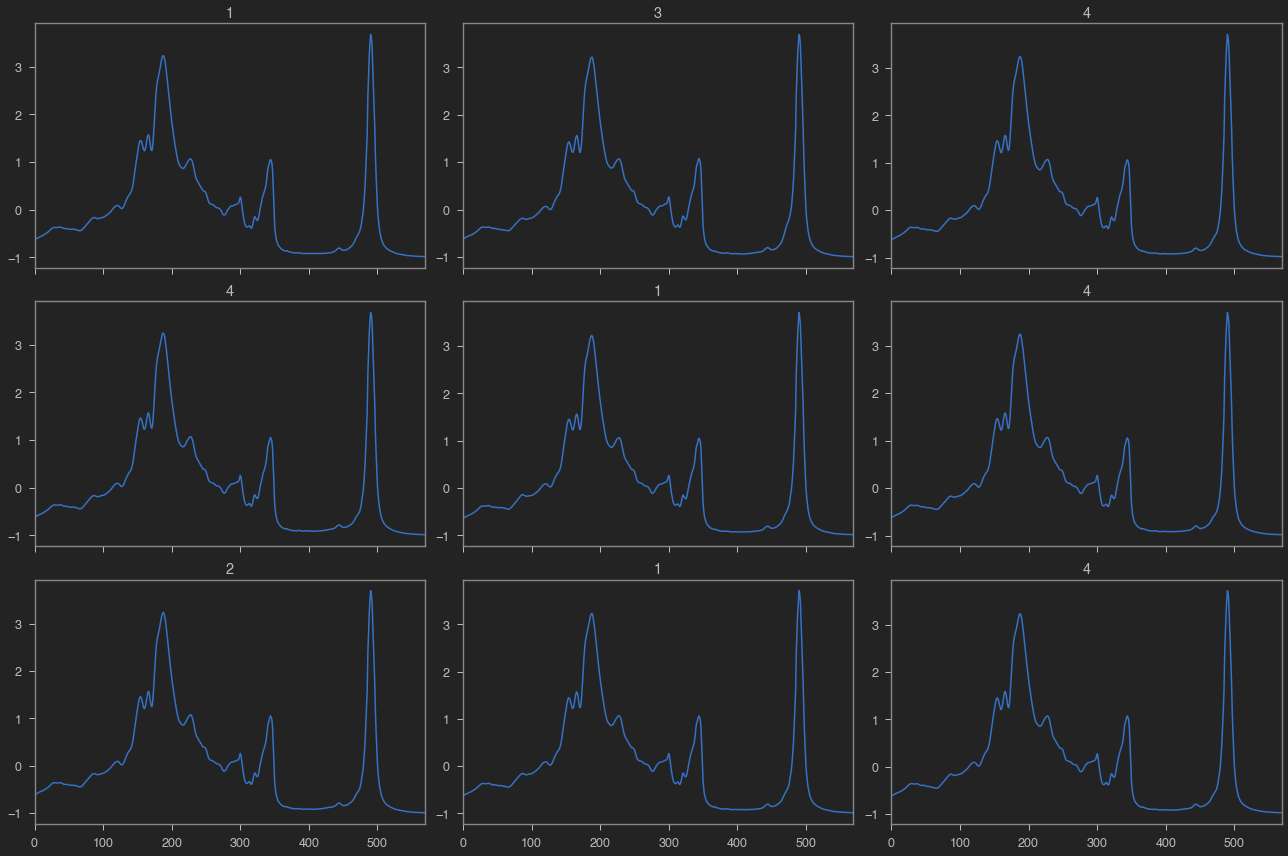

In [ ]:
learn.show_batch();

In [ ]:
learn.fit_one_cycle(2, lr_max=1e-3)

epoch,train_loss,valid_loss,time
0,1.488083,1.387229,00:05
1,1.483845,1.375471,00:10


epoch,train_loss,valid_loss,accuracy,time
0,1.386708,1.349035,0.300000,00:03
1,1.383904,1.343968,0.300000,00:02


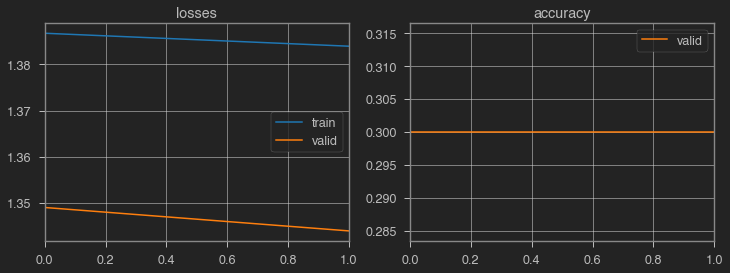

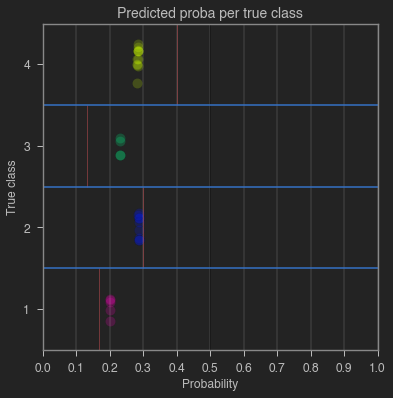

In [ ]:
dsid = 'OliveOil'
X, y, splits = get_UCR_data(dsid, split_data=False)
tfms  = [None, [Categorize()]]
dls = get_ts_dls(X, y, tfms=tfms, splits=splits)
learn = ts_learner(dls, FCNPlus, metrics=accuracy)
learn.fit_one_cycle(2)
learn.plot_metrics()
learn.show_probas()

In [ ]:
learn.save_all()
del learn
learn = load_all()

In [ ]:
test_probas, test_targets, test_preds = learn.get_X_preds(X[0:10], with_decoded=True)
test_probas, test_targets, test_preds

(tensor([[0.2016, 0.2858, 0.2298, 0.2828],
         [0.2016, 0.2858, 0.2297, 0.2828],
         [0.2016, 0.2858, 0.2298, 0.2828],
         [0.2016, 0.2858, 0.2298, 0.2828],
         [0.2016, 0.2858, 0.2298, 0.2828],
         [0.2017, 0.2858, 0.2298, 0.2828],
         [0.2017, 0.2858, 0.2298, 0.2828],
         [0.2016, 0.2858, 0.2297, 0.2828],
         [0.2017, 0.2858, 0.2298, 0.2828],
         [0.2017, 0.2858, 0.2298, 0.2828]]),
 None,
 (#10) ['2','2','2','2','2','2','2','2','2','2'])

In [ ]:
learn.fit_one_cycle(1, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.345062,1.343968,0.400000,00:03


In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 002b_data.unwindowed.ipynb.
Converted 002c_data.metadatasets.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 050_losses.ipynb.
Converted 051_metrics.ipynb.
Converted 052_learner.ipynb.
Converted 052b_tslearner.ipynb.
Converted 053_optimizer.ipynb.
Converted 060_callback.core.ipynb.
Converted 061_callback.noisy_student.ipynb.
Converted 062_callback.gblend.ipynb.
Converted 063_callback.MVP.ipynb.
Converted 064_callback.PredictionDynamics.ipynb.
Converted 100_models.layers.ipynb.
Converted 100b_models.utils.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipy